In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
BUCKET = "dept01-m4-gold"
PATH = f"s3://{BUCKET}/weather/fact_weather_hourly/"

# Leer parquet directamente desde S3
df = pd.read_parquet(PATH)

# Revisar primeras filas
df.head()


,date_key,weather_key,local_hour,is_daylight,solar_norm,wind_norm,rps_hour,wind_power_wm2,wind_speed,clouds_pct,precip_1h,humidity,temp,feels_like,city_key,event_year,event_month,event_date
0,20241001,883550,19,1,0.0,0.036821,0.014728,1.841701,2.06,20,0.0,74,27.77,30.73,678469,2024,10,2024-10-01
1,20241001,30467,20,0,0.0,0.008878,0.008878,0.485805,1.32,67,0.0,86,27.29,31.09,678469,2024,10,2024-10-01
2,20241001,538326,21,0,0.0,0.019889,0.019889,1.020108,1.69,45,0.0,86,27.12,30.64,678469,2024,10,2024-10-01
3,20241001,30467,22,0,0.0,0.018467,0.018467,0.951086,1.65,61,0.0,91,26.58,26.58,678469,2024,10,2024-10-01
4,20241001,538326,23,0,0.0,0.015442,0.015442,0.804298,1.56,45,0.0,92,26.39,26.39,678469,2024,10,2024-10-01


In [4]:
df["city_key"]

0        678469
1        678469
2        678469
3        678469
4        678469
          ...  
17565    974524
17566    974524
17567    974524
17568    974524
17569    974524
Name: city_key, Length: 17570, dtype: category
Categories (2, int32): [678469, 974524]

In [7]:
PATH = f"s3://{BUCKET}/weather/dim_city/"

# Leer parquet directamente desde S3
df = pd.read_parquet(PATH)

# Revisar primeras filas
df.head()

,city_key,city_name,lat,lon
0,974524,Patagonia,-41.810147,-68.906269
1,678469,Riohacha,11.538415,-72.916784


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import pyarrow.dataset as ds
import pyarrow.parquet as pq

import pyarrow.dataset as ds
import pyarrow.parquet as pq




# --- Configuración: bucket y ruta base ---
# Reemplaza con tu bucket Gold y la carpeta donde escribiste los parquet
BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs/solar_hr_by_month"

# --- Selección de ciudades y periodo ---
CITIES = ["Patagonia", "Riohacha"]  # Ciudades a comparar
YEAR = 2024
MONTH = 12  # Agosto

# --- Inicializar filesystem de S3 ---
# s3fs usa automáticamente ~/.aws/credentials si existe
fs = s3fs.S3FileSystem(anon=False)

# ================================================================
# 1️⃣ Leer los parquet de S3
# ================================================================

# Vamos a leer solo las particiones que nos interesan para no cargar todo
frames = []

for city in CITIES:

    dataset_path = f"{BASE_PATH}/city_name={city}/year={YEAR}/month={MONTH}/"
    dataset = ds.dataset(dataset_path, filesystem=fs, format="parquet")

    table = dataset.to_table()
    df_city = table.to_pandas()

    # Añadimos columna ciudad por si queremos mantenerla
    df_city["city"] = city
    
    # Seleccionamos columnas de interés
    df_city = df_city[["city", "local_hour", "solar_idx_mean", "avg_clouds", "precip_1h_mean", "obs_days"]]
    
    frames.append(df_city)

# Concatenamos todo en un dataframe único
df = pd.concat(frames, ignore_index=True)

# Asegurarnos que local_hour sea entero
df["local_hour"] = df["local_hour"].astype(int)

# ================================================================
# 2️⃣ Pivotar datos para gráfica comparativa
# ================================================================
# Queremos: filas=hora, columnas=ciudad, valores=solar_idx_mean
df_pivot = df.pivot_table(index="local_hour", columns="city", values="solar_idx_mean", aggfunc="mean")

# ================================================================
# 3️⃣ Gráfico comparativo por hora
# ================================================================
plt.figure(figsize=(10,5))
colors = {"Patagonia":"#e76f51", "Riohacha":"#2a9d8f"}

for city in CITIES:
    if city in df_pivot.columns:
        y = df_pivot[city].values
        x = df_pivot.index
        plt.plot(x, y, marker="o", linewidth=2.2, markersize=6, label=city, color=colors.get(city))
        
        # Marcar el pico horario
        peak_h = int(x[np.argmax(y)])
        peak_v = float(np.max(y))
        plt.scatter([peak_h], [peak_v], s=80, zorder=5, color=colors.get(city))
        plt.annotate(f"Pico {city}\n{peak_v:.2f} @ {peak_h}:00",
                     xy=(peak_h, peak_v), xytext=(peak_h+0.5, peak_v+0.02),
                     arrowprops=dict(arrowstyle="->", lw=1.5), fontsize=9)

plt.title(f"Agosto {YEAR} • Potencial solar por hora")
plt.xlabel("Hora local")
plt.ylabel("solar_idx_mean (promedio)")
plt.xticks(range(0,24,1))
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()




ArrowInvalid: GetFileInfo() yielded path 'dept01-m4-gold/weather/bqs/solar_hr_by_month/city_name=Patagonia/year=2024/month=12/part-00000-77647753-12db-4ac4-9bdf-74ddbd628c73.c000.snappy.parquet', which is outside base dir 's3://dept01-m4-gold/weather/bqs/solar_hr_by_month/city_name=Patagonia/year=2024/month=12/'

In [19]:
fs = s3fs.S3FileSystem(anon=False)

BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs/solar_hr_by_month"

print("Listing:", BASE_PATH)
fs.ls(BASE_PATH)[:10]

Listing: s3://dept01-m4-gold/weather/bqs/solar_hr_by_month


['dept01-m4-gold/weather/bqs/solar_hr_by_month/city_name=Patagonia',
 'dept01-m4-gold/weather/bqs/solar_hr_by_month/city_name=Riohacha']

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import s3fs

# --- Configuración: bucket y ruta base ---
BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs/solar_hr_by_month"

# --- Selección de ciudades ---
CITIES = ["Patagonia", "Riohacha"]  # Ciudades a comparar

# --- Inicializar filesystem de S3 ---
fs = s3fs.S3FileSystem(anon=False)

# ================================================================
# 1️⃣ Leer los parquet de S3 por ciudad
# ================================================================
frames = []

for city in CITIES:
    city_path = f"{BASE_PATH}/city_name={city}"
    
    # Listamos los archivos parquet dentro de la carpeta de la ciudad
    files = fs.ls(city_path)
    
    # Leemos cada archivo y lo acumulamos en la lista frames
    city_frames = [pd.read_parquet(f"s3://{f}", filesystem=fs) for f in files]
    
    df_city = pd.concat(city_frames, ignore_index=True)
    
    # Añadimos columna ciudad
    df_city["city"] = city
    
    # Seleccionamos columnas de interés
    df_city = df_city[["city", "local_hour", "solar_idx_mean", "avg_clouds", "precip_1h_mean", "obs_days"]]
    
    frames.append(df_city)

# Concatenamos todo en un dataframe único
df = pd.concat(frames, ignore_index=True)
df["local_hour"] = df["local_hour"].astype(int)

# ================================================================
# 2️⃣ Pivotar datos para gráfica comparativa
# ================================================================
df_pivot = df.pivot_table(index="local_hour", columns="city", values="solar_idx_mean", aggfunc="mean")

# ================================================================
# 3️⃣ Gráfico comparativo por hora
# ================================================================
plt.figure(figsize=(10,5))
colors = {"Patagonia":"#e76f51", "Riohacha":"#2a9d8f"}

for city in CITIES:
    if city in df_pivot.columns:
        x = df_pivot.index
        y = df_pivot[city].values
        plt.plot(x, y, marker="o", linewidth=2.2, markersize=6, label=city, color=colors[city])
        
        # Marcar el pico horario
        peak_h = int(x[np.argmax(y)])
        peak_v = float(np.max(y))
        plt.scatter([peak_h], [peak_v], s=80, zorder=5, color=colors[city])
        plt.annotate(f"Pico {city}\n{peak_v:.2f} @ {peak_h}:00",
                     xy=(peak_h, peak_v), xytext=(peak_h+0.5, peak_v+0.02),
                     arrowprops=dict(arrowstyle="->", lw=1.5), fontsize=9)

plt.title(f"Potencial solar por hora")
plt.xlabel("Hora local")
plt.ylabel("solar_idx_mean (promedio)")
plt.xticks(range(0,24,1))
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


ArrowInvalid: GetFileInfo() yielded path 'dept01-m4-gold/weather/bqs/solar_hr_by_month/city_name=Patagonia/year=2024/month=9/part-00000-77647753-12db-4ac4-9bdf-74ddbd628c73.c000.snappy.parquet', which is outside base dir 's3://dept01-m4-gold/weather/bqs/solar_hr_by_month/city_name=Patagonia/year=2024'

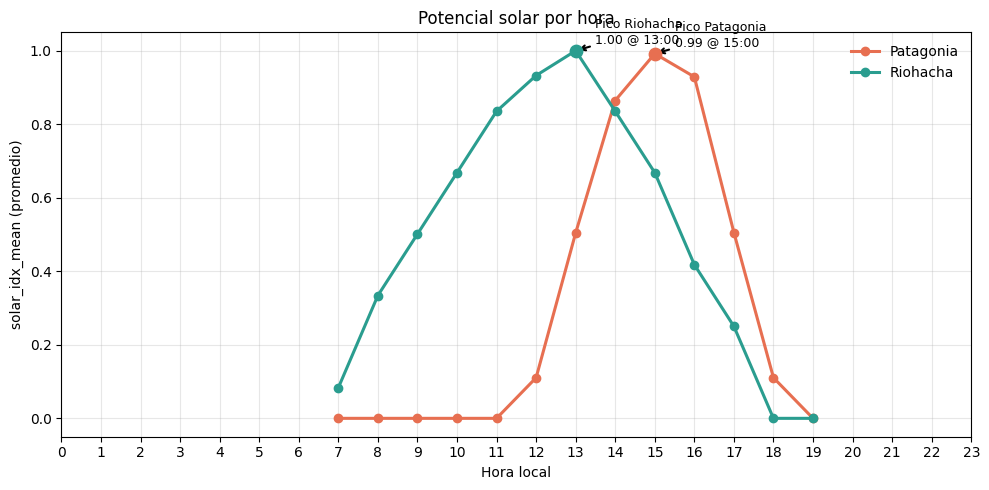

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import s3fs

BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs/solar_hr_by_month"
CITIES = ["Patagonia", "Riohacha"]

fs = s3fs.S3FileSystem(anon=False)

frames = []

for city in CITIES:
    city_path = f"{BASE_PATH}/city_name={city}"
    
    # Recorremos todas las subcarpetas recursivamente
    files = fs.glob(f"{city_path}/**/*.parquet")
    
    city_frames = [pd.read_parquet(f"s3://{f}", filesystem=fs) for f in files]
    df_city = pd.concat(city_frames, ignore_index=True)
    
    df_city["city"] = city
    df_city = df_city[["city", "local_hour", "solar_idx_mean", "avg_clouds", "precip_1h_mean", "obs_days"]]
    
    frames.append(df_city)

df = pd.concat(frames, ignore_index=True)
df["local_hour"] = df["local_hour"].astype(int)

# Pivot para gráfica comparativa
df_pivot = df.pivot_table(index="local_hour", columns="city", values="solar_idx_mean", aggfunc="mean")

# Gráfico
plt.figure(figsize=(10,5))
colors = {"Patagonia":"#e76f51", "Riohacha":"#2a9d8f"}

for city in CITIES:
    if city in df_pivot.columns:
        x = df_pivot.index
        y = df_pivot[city].values
        plt.plot(x, y, marker="o", linewidth=2.2, markersize=6, label=city, color=colors[city])
        
        peak_h = int(x[np.argmax(y)])
        peak_v = float(np.max(y))
        plt.scatter([peak_h], [peak_v], s=80, zorder=5, color=colors[city])
        plt.annotate(f"Pico {city}\n{peak_v:.2f} @ {peak_h}:00",
                     xy=(peak_h, peak_v), xytext=(peak_h+0.5, peak_v+0.02),
                     arrowprops=dict(arrowstyle="->", lw=1.5), fontsize=9)

plt.title("Potencial solar por hora")
plt.xlabel("Hora local")
plt.ylabel("solar_idx_mean (promedio)")
plt.xticks(range(0,24,1))
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


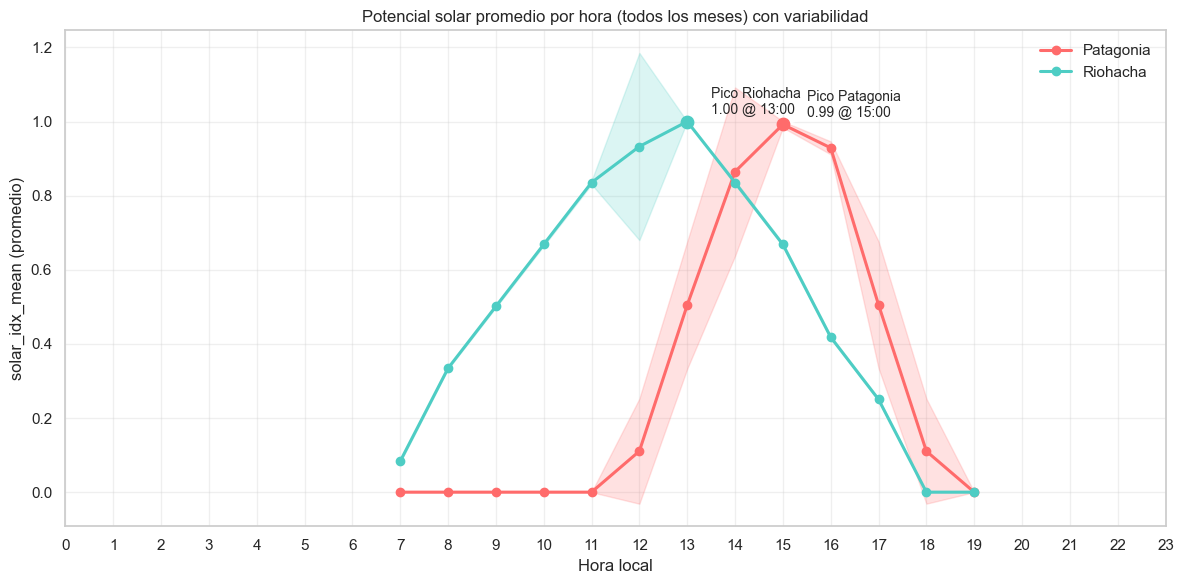

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import seaborn as sns

# Estilo de seaborn para gráficos más bonitos
sns.set(style="whitegrid")

BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs/solar_hr_by_month"
CITIES = ["Patagonia", "Riohacha"]

fs = s3fs.S3FileSystem(anon=False)
frames = []

for city in CITIES:
    city_path = f"{BASE_PATH}/city_name={city}"
    files = fs.glob(f"{city_path}/**/*.parquet")
    city_frames = [pd.read_parquet(f"s3://{f}", filesystem=fs) for f in files]
    df_city = pd.concat(city_frames, ignore_index=True)
    df_city["city"] = city
    df_city = df_city[["city", "local_hour", "solar_idx_mean", "avg_clouds", "precip_1h_mean", "obs_days"]]
    frames.append(df_city)

df = pd.concat(frames, ignore_index=True)
df["local_hour"] = df["local_hour"].astype(int)

# ================================================================
# Promedio y desviación estándar por hora para cada ciudad
# ================================================================
df_stats = df.groupby(["local_hour", "city"])["solar_idx_mean"].agg(['mean','std']).reset_index()

# Pivot para gráficos
df_mean = df_stats.pivot(index="local_hour", columns="city", values="mean")
df_std  = df_stats.pivot(index="local_hour", columns="city", values="std")

# Colores modernos
colors = {"Patagonia":"#ff6b6b", "Riohacha":"#4ecdc4"}

plt.figure(figsize=(12,6))

for city in CITIES:
    if city in df_mean.columns:
        x = df_mean.index
        y = df_mean[city].values
        y_std = df_std[city].values
        
        # Línea promedio
        plt.plot(x, y, marker="o", linewidth=2.2, markersize=6, label=city, color=colors[city])
        
        # Banda de ±1 std
        plt.fill_between(x, y-y_std, y+y_std, color=colors[city], alpha=0.2)
        
        # Pico horario
        peak_h = int(x[np.argmax(y)])
        peak_v = float(np.max(y))
        plt.scatter([peak_h], [peak_v], s=80, zorder=5, color=colors[city])
        plt.annotate(f"Pico {city}\n{peak_v:.2f} @ {peak_h}:00",
                     xy=(peak_h, peak_v), xytext=(peak_h+0.5, peak_v+0.02),
                     arrowprops=dict(arrowstyle="->", lw=1.5), fontsize=10)

plt.title("Potencial solar promedio por hora (todos los meses) con variabilidad")
plt.xlabel("Hora local")
plt.ylabel("solar_idx_mean (promedio)")
plt.xticks(range(0,24,1))
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


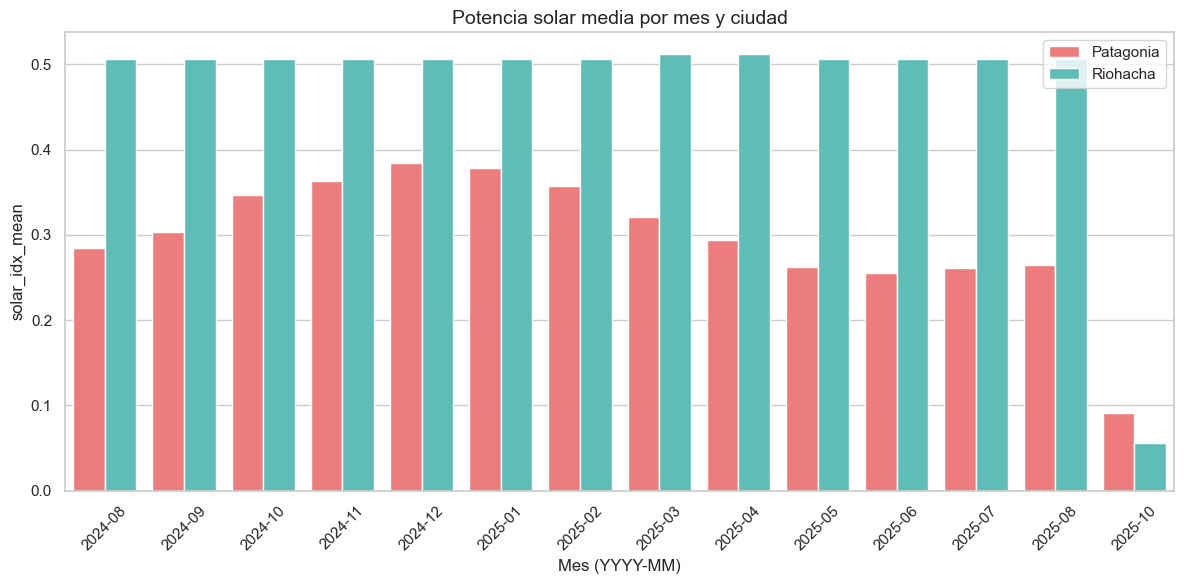

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import s3fs
import seaborn as sns

# --- Configuración ---
BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs/solar_hr_by_month"
CITIES = ["Patagonia", "Riohacha"]

# Inicializar filesystem S3
fs = s3fs.S3FileSystem(anon=False)

# ================================================================
# 1️⃣ Leer todos los parquet y agregar columnas city, year, month
# ================================================================
frames = []

for city in CITIES:
    city_path = f"{BASE_PATH}/city_name={city}"
    
    # Listar años
    years = fs.ls(city_path)
    for year_path in years:
        year = int(year_path.split("year=")[1])
        
        # Listar meses dentro del año
        months = fs.ls(year_path)
        for month_path in months:
            # Saltar si no es una carpeta de month
            if "month=" not in month_path:
                continue
            month = int(month_path.split("month=")[1])
            
            # Listar archivos parquet dentro del mes
            files = fs.ls(month_path)
            for f in files:
                df_city = pd.read_parquet(f"s3://{f}", filesystem=fs)
                df_city["city"] = city
                df_city["year"] = year
                df_city["month"] = month
                frames.append(df_city)

# Concatenar todo
df = pd.concat(frames, ignore_index=True)

# ================================================================
# 2️⃣ Agrupar por año, mes y ciudad, promedio solar_idx_mean
# ================================================================
df_grouped = df.groupby(["year", "month", "city"])["solar_idx_mean"].mean().reset_index()

# Crear columna para etiquetas "YYYY-MM"
df_grouped["year_month"] = df_grouped["year"].astype(str) + "-" + df_grouped["month"].astype(str).str.zfill(2)

# ================================================================
# 3️⃣ Gráfico de barras: potencia solar media por mes y ciudad
# ================================================================
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

# Elegimos una paleta moderna
palette = {"Patagonia":"#ff6b6b", "Riohacha":"#4ecdc4"}

sns.barplot(
    data=df_grouped,
    x="year_month",
    y="solar_idx_mean",
    hue="city",
    palette=palette
)

plt.title("Potencia solar media por mes y ciudad", fontsize=14)
plt.xlabel("Mes (YYYY-MM)")
plt.ylabel("solar_idx_mean")
plt.xticks(rotation=45)
plt.legend(title="")
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import s3fs
import numpy as np

# =========================
# Configuración
# =========================
BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs/wind_hr_by_month"
CITIES = ["Patagonia", "Riohacha"]

fs = s3fs.S3FileSystem(anon=False)

# =========================
# 1️⃣ Leer los parquet de S3
# =========================
frames = []

for city in CITIES:
    city_path = f"{BASE_PATH}/city_name={city}"
    
    # Listar subcarpetas año/mes
    try:
        year_month_folders = fs.ls(city_path)
    except:
        print(f"No se encontraron carpetas para {city}")
        continue
    
    for folder in year_month_folders:
        files = fs.ls(folder)
        for f in files:
            if f.endswith(".parquet"):
                parts = f.split("/")
                year_part = [p for p in parts if p.startswith("year=")]
                month_part = [p for p in parts if p.startswith("month=")]
                if year_part and month_part:
                    year = int(year_part[0].split("=")[1])
                    month = int(month_part[0].split("=")[1])
                    
                    df_file = pd.read_parquet(f"s3://{f}", filesystem=fs)
                    df_file["city_name"] = city
                    df_file["year"] = year
                    df_file["month"] = month
                    frames.append(df_file)

if not frames:
    raise ValueError("No se encontraron archivos parquet para las ciudades seleccionadas")

df_wind = pd.concat(frames, ignore_index=True)

# =========================
# 2️⃣ Gráfico de línea: promedio por hora
# =========================
# Agrupamos por ciudad y hora
df_hourly = df_wind.groupby(["city_name", "local_hour"])[["wind_idx_mean", "wind_power_wm2_mean"]].mean().reset_index()

plt.figure(figsize=(10,5))
sns.set(style="whitegrid")

# Colores copados
colors = {"Patagonia": "#ff6f61", "Riohacha": "#4db6ac"}

for city in CITIES:
    df_city = df_hourly[df_hourly["city_name"] == city]
    x = df_city["local_hour"]
    y = df_city["wind_power_wm2_mean"]  # o "wind_idx_mean"
    plt.plot(x, y, marker="o", linewidth=2, markersize=6, label=city, color=colors[city])
    
    # Marcar el pico horario
    peak_h = int(x[np.argmax(y)])
    peak_v = float(np.max(y))
    plt.scatter([peak_h], [peak_v], s=80, zorder=5, color=colors[city])
    plt.annotate(f"Pico {city}\n{peak_v:.2f} @ {peak_h}:00",
                 xy=(peak_h, peak_v), xytext=(peak_h+0.5, peak_v+0.02),
                 arrowprops=dict(arrowstyle="->", lw=1.5), fontsize=9)

plt.title("Promedio de potencia de viento por hora")
plt.xlabel("Hora local")
plt.ylabel("Potencia de viento (W/m²)")
plt.xticks(range(0,24,1))
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


ValueError: No se encontraron archivos parquet para las ciudades seleccionadas

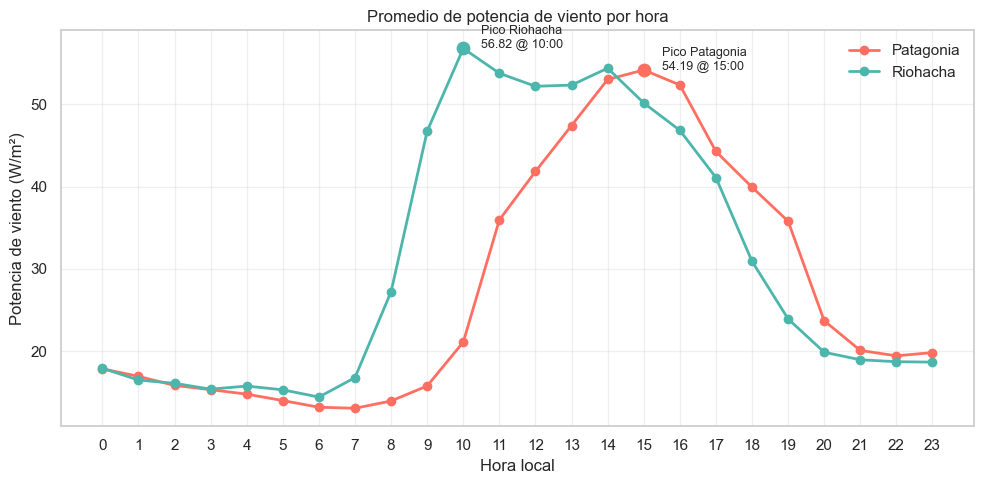

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import s3fs
import numpy as np

# =========================
# Configuración
# =========================
BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs/wind_hr_by_month"
CITIES = ["Patagonia", "Riohacha"]

fs = s3fs.S3FileSystem(anon=False)

# =========================
# 1️⃣ Leer los parquet de S3
# =========================
frames = []

for city in CITIES:
    city_path = f"{BASE_PATH}/city_name={city}"
    
    # Listar carpetas año/mes
    try:
        year_folders = fs.ls(city_path)
    except:
        print(f"No se encontraron carpetas para {city}")
        continue
    
    for year_folder in year_folders:
        month_folders = fs.ls(year_folder)
        for month_folder in month_folders:
            files = fs.ls(month_folder)
            for f in files:
                if f.endswith(".parquet"):
                    parts = f.split("/")
                    year_part = [p for p in parts if p.startswith("year=")]
                    month_part = [p for p in parts if p.startswith("month=")]
                    if year_part and month_part:
                        year = int(year_part[0].split("=")[1])
                        month = int(month_part[0].split("=")[1])
                        
                        df_file = pd.read_parquet(f"s3://{f}", filesystem=fs)
                        df_file["city_name"] = city
                        df_file["year"] = year
                        df_file["month"] = month
                        frames.append(df_file)

if not frames:
    raise ValueError("No se encontraron archivos parquet para las ciudades seleccionadas")

df_wind = pd.concat(frames, ignore_index=True)

# =========================
# 2️⃣ Gráfico de línea: promedio por hora
# =========================
# Agrupar por ciudad y hora
df_hourly = df_wind.groupby(["city_name", "local_hour"])[["wind_idx_mean", "wind_power_wm2_mean"]].mean().reset_index()

plt.figure(figsize=(10,5))
sns.set(style="whitegrid")

# Colores más copados
colors = {"Patagonia": "#ff6f61", "Riohacha": "#4db6ac"}

for city in CITIES:
    df_city = df_hourly[df_hourly["city_name"] == city]
    x = df_city["local_hour"]
    y = df_city["wind_power_wm2_mean"]  # también podrías usar "wind_idx_mean"
    
    plt.plot(x, y, marker="o", linewidth=2, markersize=6, label=city, color=colors[city])
    
    # Marcar el pico horario usando .iloc
    peak_idx = np.argmax(y)
    peak_h = int(x.iloc[peak_idx])
    peak_v = float(y.iloc[peak_idx])
    
    plt.scatter([peak_h], [peak_v], s=80, zorder=5, color=colors[city])
    plt.annotate(f"Pico {city}\n{peak_v:.2f} @ {peak_h}:00",
                 xy=(peak_h, peak_v), xytext=(peak_h+0.5, peak_v+0.02),
                 arrowprops=dict(arrowstyle="->", lw=1.5), fontsize=9)

plt.title("Promedio de potencia de viento por hora")
plt.xlabel("Hora local")
plt.ylabel("Potencia de viento (W/m²)")
plt.xticks(range(0,24,1))
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


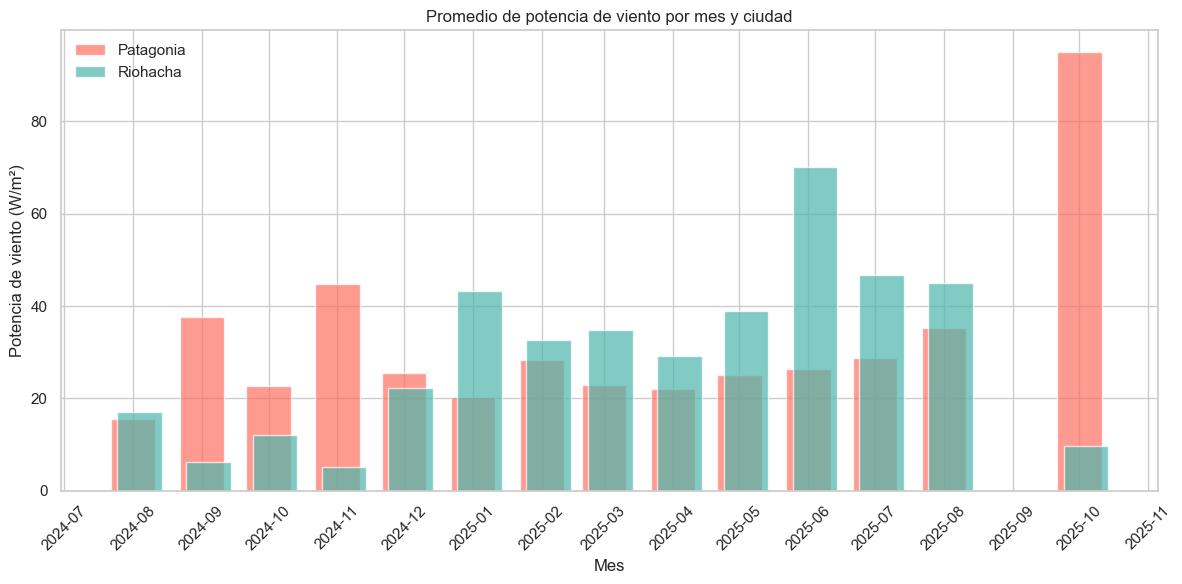

In [32]:
# =========================
# 3️⃣ Gráfico de barras: promedio por año y mes
# =========================
import matplotlib.dates as mdates

# Agrupamos por ciudad, año y mes
df_grouped = df_wind.groupby(["city_name", "year", "month"])[["wind_idx_mean", "wind_power_wm2_mean"]].mean().reset_index()

# Creamos columna "YYYY-MM" para el eje x
df_grouped["year_month"] = pd.to_datetime(df_grouped["year"].astype(str) + "-" + df_grouped["month"].astype(str) + "-01")

plt.figure(figsize=(12,6))
sns.set(style="whitegrid")

colors = {"Patagonia": "#ff6f61", "Riohacha": "#4db6ac"}

for city in CITIES:
    df_city = df_grouped[df_grouped["city_name"] == city]
    plt.bar(df_city["year_month"] + pd.to_timedelta(0 if city=="Patagonia" else 3, unit='d'), 
            df_city["wind_power_wm2_mean"], 
            width=20, label=city, color=colors[city], alpha=0.7)

plt.title("Promedio de potencia de viento por mes y ciudad")
plt.xlabel("Mes")
plt.ylabel("Potencia de viento (W/m²)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


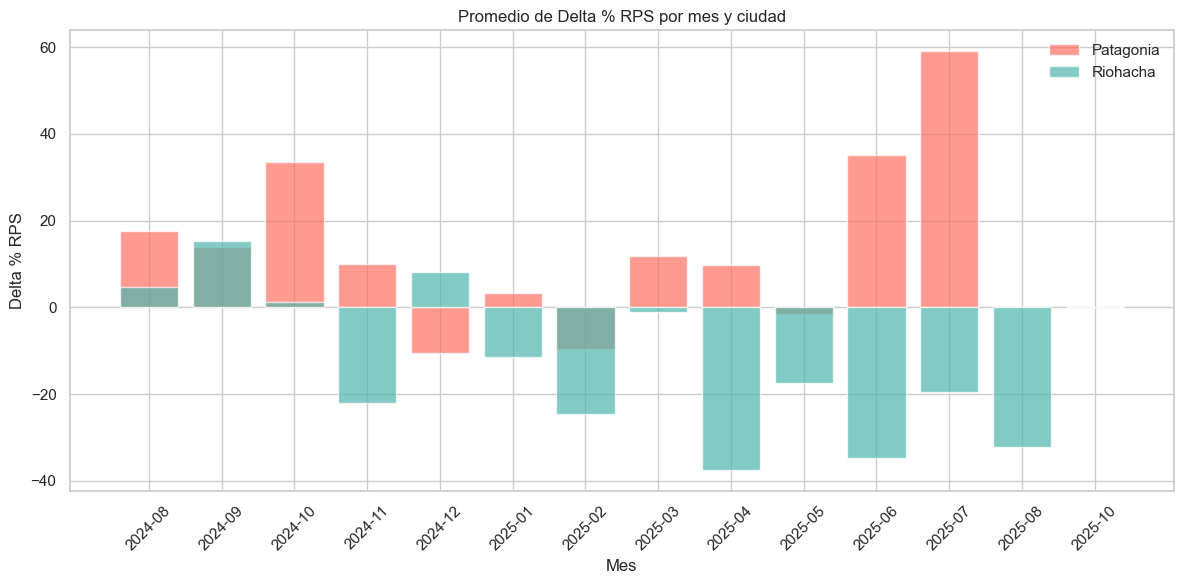

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import s3fs
import numpy as np

# =========================
# Configuración
# =========================
BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs/rps_var"
CITIES = ["Patagonia", "Riohacha"]

fs = s3fs.S3FileSystem(anon=False)

# =========================
# 1️⃣ Leer parquet de RPS desde S3
# =========================
frames = []

for city in CITIES:
    city_path = f"{BASE_PATH}/city_name={city}"
    
    try:
        year_folders = fs.ls(city_path)
    except:
        print(f"No se encontraron carpetas para {city}")
        continue
    
    for year_folder in year_folders:
        month_folders = fs.ls(year_folder)
        for month_folder in month_folders:
            files = fs.ls(month_folder)
            for f in files:
                if f.endswith(".parquet"):
                    parts = f.split("/")
                    year_part = [p for p in parts if p.startswith("year=")]
                    month_part = [p for p in parts if p.startswith("month=")]
                    if year_part and month_part:
                        year = int(year_part[0].split("=")[1])
                        month = int(month_part[0].split("=")[1])
                        
                        df_file = pd.read_parquet(f"s3://{f}", filesystem=fs)
                        df_file["city_name"] = city
                        df_file["year"] = year
                        df_file["month"] = month
                        frames.append(df_file)

if not frames:
    raise ValueError("No se encontraron archivos parquet para las ciudades seleccionadas")

df_rps = pd.concat(frames, ignore_index=True)

# =========================
# 2️⃣ Gráfico de barras: rps_delta_pct promedio por mes
# =========================
# Crear columna "YYYY-MM" para ordenar en el eje x
df_rps["year_month"] = df_rps["year"].astype(str) + "-" + df_rps["month"].astype(str).str.zfill(2)

# Agrupar por ciudad y mes
df_monthly = df_rps.groupby(["city_name","year_month"])["rps_delta_pct"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.set(style="whitegrid")

colors = {"Patagonia": "#ff6f61", "Riohacha": "#4db6ac"}

for city in CITIES:
    df_city = df_monthly[df_monthly["city_name"] == city].sort_values("year_month")
    plt.bar(df_city["year_month"], df_city["rps_delta_pct"], 
            label=city, color=colors[city], alpha=0.7)

plt.xticks(rotation=45)
plt.ylabel("Delta % RPS")
plt.xlabel("Mes")
plt.title("Promedio de Delta % RPS por mes y ciudad")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [61]:
import pyarrow.parquet as pq
import pandas as pd
import s3fs

fs = s3fs.S3FileSystem(anon=False)

files = [
    "s3://dept01-m4-gold/weather/bqs/day_vs_last_year_day/date=2025-10-23/city_name=Patagonia/part-00000-0e88dd22-04b1-4a62-a805-15a622002bee.c000.snappy.parquet",
    "s3://dept01-m4-gold/weather/bqs/day_vs_last_year_day/date=2025-10-23/city_name=Riohacha/part-00000-0e88dd22-04b1-4a62-a805-15a622002bee.c000.snappy.parquet"
]

for f in files:
    print(f"\n📂 Leyendo archivo: {f}")

    # Forzamos lectura "bruta" sin intentar unificar tipos
    with fs.open(f, 'rb') as fobj:
        pf = pq.ParquetFile(fobj)
        dfs = []
        for i in range(pf.num_row_groups):
            table = pf.read_row_group(i)
            df = table.to_pandas()
            dfs.append(df)

        df_all = pd.concat(dfs, ignore_index=True)

        # Normalizamos la columna date a string
        if "date" in df_all.columns:
            df_all["date"] = df_all["date"].astype(str)

        print(df_all.head())
        print(f"Columnas: {df_all.columns.tolist()}")
        print(f"Tipos:\n{df_all.dtypes}")



📂 Leyendo archivo: s3://dept01-m4-gold/weather/bqs/day_vs_last_year_day/date=2025-10-23/city_name=Patagonia/part-00000-0e88dd22-04b1-4a62-a805-15a622002bee.c000.snappy.parquet
         date  rps_today  rps_last_year  diff_abs    diff_pct
0  2025-10-23   0.454495       0.142868  0.311628  218.123601
Columnas: ['date', 'rps_today', 'rps_last_year', 'diff_abs', 'diff_pct']
Tipos:
date              object
rps_today        float64
rps_last_year    float64
diff_abs         float64
diff_pct         float64
dtype: object

📂 Leyendo archivo: s3://dept01-m4-gold/weather/bqs/day_vs_last_year_day/date=2025-10-23/city_name=Riohacha/part-00000-0e88dd22-04b1-4a62-a805-15a622002bee.c000.snappy.parquet
         date  rps_today  rps_last_year  diff_abs   diff_pct
0  2025-10-23   0.112695       0.180881 -0.068186 -37.696731
Columnas: ['date', 'rps_today', 'rps_last_year', 'diff_abs', 'diff_pct']
Tipos:
date              object
rps_today        float64
rps_last_year    float64
diff_abs         float64
di

In [64]:
import pandas as pd
import s3fs

# =========================
# Configuración
# =========================
BUCKET = "dept01-m4-gold"
PATH_TOP = f"s3://{BUCKET}/bqs/best_days_top"
PATH_BOTTOM = f"s3://{BUCKET}/bqs/worst_days_top"

fs = s3fs.S3FileSystem(anon=False)

# =========================
# Leer Parquet
# =========================
print("📥 Leyendo Parquet desde S3...")

df_top = pd.read_parquet(PATH_TOP, filesystem=fs)
df_bottom = pd.read_parquet(PATH_BOTTOM, filesystem=fs)

# Agregar etiqueta
df_top["type"] = "best"
df_bottom["type"] = "worst"

# Unir ambos
df_all = pd.concat([df_top, df_bottom], ignore_index=True)

# =========================
# Mostrar datos
# =========================
print("\n✅ Data leída correctamente:")
print(df_all.head(20))  # muestra primeras 20 filas

print("\n📊 Columnas disponibles:")
print(df_all.columns.tolist())

print(f"\nTotal de registros: {len(df_all)}")


📥 Leyendo Parquet desde S3...


FileNotFoundError: s3://dept01-m4-gold/bqs/best_days_top

In [66]:
import pandas as pd
import s3fs

# =========================
# Configuración
# =========================
BUCKET = "dept01-m4-gold"
BASE_PATH = "s3://dept01-m4-gold/weather/bqs"
fs = s3fs.S3FileSystem(anon=False)

# =========================
# 1️⃣ Ver estructura de carpetas
# =========================
print("📂 Carpetas disponibles en el bucket:")
folders = fs.ls(BASE_PATH)
for f in folders:
    print(" -", f)

# =========================
# 2️⃣ Leer recursivamente los Parquet
# =========================
def read_all_parquet(path):
    """Lee todos los archivos Parquet dentro de un path S3 (recursivo)."""
    print(f"\n📥 Buscando archivos en: {path}")
    files = fs.find(path)  # busca en todas las subcarpetas
    parquet_files = [f for f in files if f.endswith(".parquet")]
    
    if not parquet_files:
        print(f"⚠️ No se encontraron archivos .parquet en {path}")
        return None
    
    print(f"Encontrados {len(parquet_files)} archivos parquet.")
    return pd.concat([pd.read_parquet(f"s3://{f}", filesystem=fs) for f in parquet_files], ignore_index=True)

# Leer “best” y “worst”
df_top = read_all_parquet(f"{BASE_PATH}/best_days_top")
df_bottom = read_all_parquet(f"{BASE_PATH}/worst_days_top")

# ==================


📂 Carpetas disponibles en el bucket:
 - dept01-m4-gold/weather/bqs/best_days_top
 - dept01-m4-gold/weather/bqs/day_vs_last_year_day
 - dept01-m4-gold/weather/bqs/htemps_top
 - dept01-m4-gold/weather/bqs/ltemps_top
 - dept01-m4-gold/weather/bqs/rps_var
 - dept01-m4-gold/weather/bqs/solar_hr_by_month
 - dept01-m4-gold/weather/bqs/wind_hr_by_month
 - dept01-m4-gold/weather/bqs/worst_days_top

📥 Buscando archivos en: s3://dept01-m4-gold/weather/bqs/best_days_top
Encontrados 28 archivos parquet.

📥 Buscando archivos en: s3://dept01-m4-gold/weather/bqs/worst_days_top
Encontrados 28 archivos parquet.


In [68]:
import pandas as pd
import s3fs

# =========================
# ⚙️ Configuración
# =========================
BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs"
fs = s3fs.S3FileSystem(anon=False)

# =========================
# 1️⃣ Ver estructura de carpetas
# =========================
print("📂 Carpetas disponibles en el bucket:")
try:
    folders = fs.ls(BASE_PATH)
    for f in folders:
        print(" -", f)
except FileNotFoundError:
    raise ValueError(f"❌ No se encontró la ruta {BASE_PATH}. Verifica el nombre o permisos de S3.")

# =========================
# 2️⃣ Leer recursivamente los Parquet
# =========================
def read_all_parquet(path):
    """Lee todos los archivos Parquet dentro de un path S3 (recursivo)."""
    print(f"\n📥 Buscando archivos en: {path}")
    files = fs.find(path)
    parquet_files = [f for f in files if f.endswith(".parquet")]
    
    if not parquet_files:
        print(f"⚠️ No se encontraron archivos .parquet en {path}")
        return None
    
    print(f"✅ Encontrados {len(parquet_files)} archivos parquet.")
    dfs = [pd.read_parquet(f"s3://{f}", filesystem=fs) for f in parquet_files]
    return pd.concat(dfs, ignore_index=True)

# =========================
# 3️⃣ Leer “best” y “worst”
# =========================
df_top = read_all_parquet(f"{BASE_PATH}/best_days_top")
df_bottom = read_all_parquet(f"{BASE_PATH}/worst_days_top")

# =========================
# 4️⃣ Combinar y mostrar resultados
# =========================
frames = []
if df_top is not None:
    df_top["type"] = "best"
    frames.append(df_top)
if df_bottom is not None:
    df_bottom["type"] = "worst"
    frames.append(df_bottom)

if not frames:
    raise ValueError("❌ No se encontraron archivos Parquet en ninguna carpeta.")

df_all = pd.concat(frames, ignore_index=True)

# =========================
# 5️⃣ Mostrar datos
# =========================
print("\n✅ Primeras filas:")
print(df_all.head(5))

print("\n✅ Últimas filas:")
print(df_all.tail(5))

print("\n📊 Columnas disponibles:")
print(df_all.columns.tolist())

print(f"\nTotal de registros: {len(df_all)}")

# =========================
# 6️⃣ Resumen rápido por ciudad (si existen columnas)
# =========================
if "city_name" in df_all.columns and "rps_day" in df_all.columns:
    resumen = df_all.groupby(["city_name", "type"])["rps_day"].mean().reset_index()
    print("\n📈 Promedio de rps_day por ciudad y tipo:")
    print(resumen)


📂 Carpetas disponibles en el bucket:
 - dept01-m4-gold/weather/bqs/best_days_top
 - dept01-m4-gold/weather/bqs/day_vs_last_year_day
 - dept01-m4-gold/weather/bqs/htemps_top
 - dept01-m4-gold/weather/bqs/ltemps_top
 - dept01-m4-gold/weather/bqs/rps_var
 - dept01-m4-gold/weather/bqs/solar_hr_by_month
 - dept01-m4-gold/weather/bqs/wind_hr_by_month
 - dept01-m4-gold/weather/bqs/worst_days_top

📥 Buscando archivos en: s3://dept01-m4-gold/weather/bqs/best_days_top
✅ Encontrados 28 archivos parquet.

📥 Buscando archivos en: s3://dept01-m4-gold/weather/bqs/worst_days_top
✅ Encontrados 28 archivos parquet.

✅ Primeras filas:
   date_key  city_key  event_date  hours_observed  solar_idx_day  \
0  20241025    974524  2024-10-25              24       0.352152   
1  20241026    974524  2024-10-26              24       0.340155   
2  20241002    974524  2024-10-02              24       0.347212   
3  20241001    974524  2024-10-01              24       0.355681   
4  20241011    974524  2024-10-11   


📥 Buscando archivos en: s3://dept01-m4-gold/weather/bqs/htemps_top

📥 Buscando archivos en: s3://dept01-m4-gold/weather/bqs/ltemps_top

🔥 Top 5 días más calientes:
    city_name        date  max_temp  year  month
77   Riohacha  2024-08-20     34.69  2024      8
78   Riohacha  2024-08-04     34.25  2024      8
113  Riohacha  2025-06-08     34.20  2025      6
82   Riohacha  2024-09-16     34.20  2024      9
79   Riohacha  2024-08-19     34.19  2024      8

❄️ Top 5 días más fríos:
    city_name        date  min_temp  year  month
51  Patagonia  2025-06-29    -15.01  2025      6
52  Patagonia  2025-06-30    -14.73  2025      6
53  Patagonia  2025-06-28    -11.78  2025      6
56  Patagonia  2025-07-01    -11.01  2025      7
57  Patagonia  2025-07-02     -9.11  2025      7


C:\Users\c4dex\AppData\Local\Temp\ipykernel_34460\2469719084.py:70: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\c4dex\AppData\Local\Temp\ipykernel_34460\2469719084.py:70: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\c4dex\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\c4dex\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


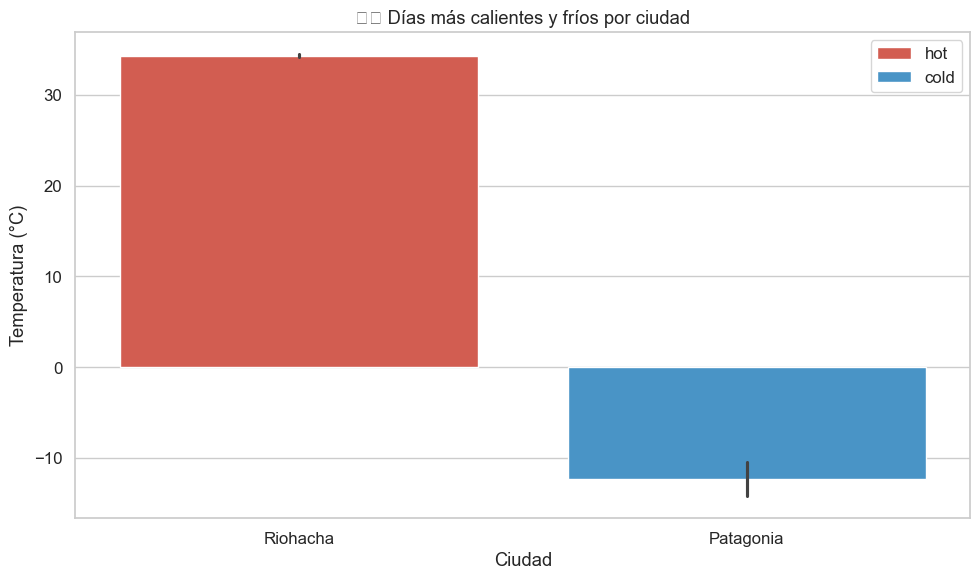

In [69]:
import pandas as pd
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# ⚙️ Configuración
# =========================
BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs"
fs = s3fs.S3FileSystem(anon=False)

# =========================
# 1️⃣ Función para leer recursivamente
# =========================
def read_all_parquet(path):
    print(f"\n📥 Buscando archivos en: {path}")
    files = fs.find(path)
    parquet_files = [f for f in files if f.endswith(".parquet")]
    if not parquet_files:
        print(f"⚠️ No se encontraron archivos parquet en {path}")
        return None
    return pd.concat([pd.read_parquet(f"s3://{f}", filesystem=fs) for f in parquet_files], ignore_index=True)

# =========================
# 2️⃣ Leer datasets de temperaturas
# =========================
df_hot = read_all_parquet(f"{BASE_PATH}/htemps_top")
df_cold = read_all_parquet(f"{BASE_PATH}/ltemps_top")

if df_hot is None or df_cold is None:
    raise ValueError("❌ No se pudieron leer los archivos de temperaturas desde S3.")

df_hot["type"] = "hot"
df_cold["type"] = "cold"

df_all = pd.concat([df_hot, df_cold], ignore_index=True)

# =========================
# 3️⃣ Mostrar los 5 más calientes y 5 más fríos
# =========================
top5_hot = df_hot.sort_values("max_temp", ascending=False).head(5)
top5_cold = df_cold.sort_values("min_temp", ascending=True).head(5)

print("\n🔥 Top 5 días más calientes:")
print(top5_hot[["city_name", "date", "max_temp", "year", "month"]])

print("\n❄️ Top 5 días más fríos:")
print(top5_cold[["city_name", "date", "min_temp", "year", "month"]])

# =========================
# 4️⃣ Gráfico comparativo
# =========================
sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(10,6))
sns.barplot(
    data=pd.concat([
        top5_hot.assign(temp=top5_hot["max_temp"]),
        top5_cold.assign(temp=top5_cold["min_temp"])
    ]),
    x="city_name", y="temp", hue="type",
    palette={"hot": "#e74c3c", "cold": "#3498db"}
)

plt.title("🌡️ Días más calientes y fríos por ciudad")
plt.xlabel("Ciudad")
plt.ylabel("Temperatura (°C)")
plt.legend(title="")
plt.tight_layout()
plt.show()



📥 Buscando archivos en: s3://dept01-m4-gold/weather/bqs/htemps_top

📥 Buscando archivos en: s3://dept01-m4-gold/weather/bqs/ltemps_top


C:\Users\c4dex\AppData\Local\Temp\ipykernel_34460\2897126285.py:85: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\c4dex\AppData\Local\Temp\ipykernel_34460\2897126285.py:85: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\c4dex\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\c4dex\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


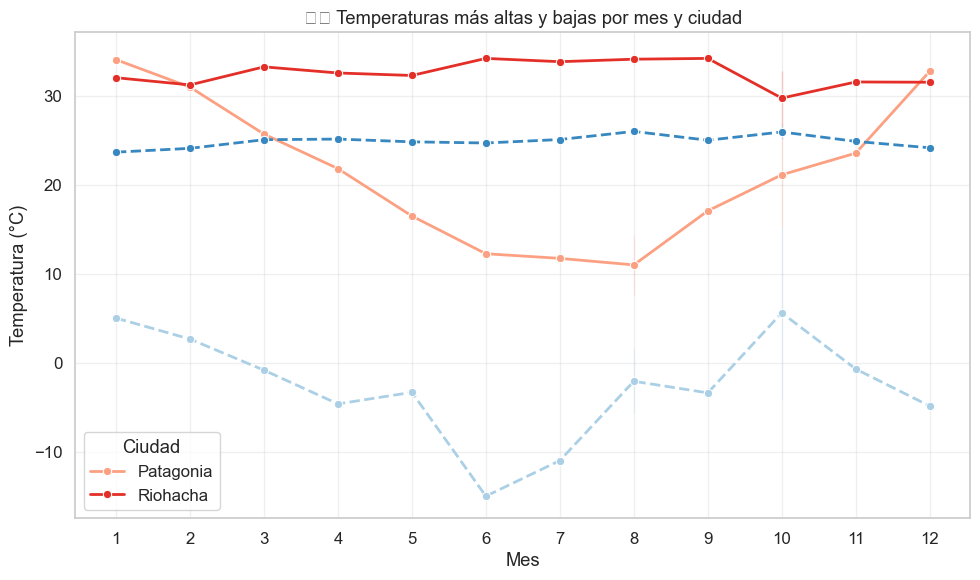

In [70]:
import pandas as pd
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# ⚙️ Configuración
# =========================
BUCKET = "dept01-m4-gold"
BASE_PATH = f"s3://{BUCKET}/weather/bqs"
fs = s3fs.S3FileSystem(anon=False)

# =========================
# 1️⃣ Función para leer recursivamente
# =========================
def read_all_parquet(path):
    print(f"\n📥 Buscando archivos en: {path}")
    files = fs.find(path)
    parquet_files = [f for f in files if f.endswith(".parquet")]
    if not parquet_files:
        print(f"⚠️ No se encontraron archivos parquet en {path}")
        return None
    return pd.concat([pd.read_parquet(f"s3://{f}", filesystem=fs) for f in parquet_files], ignore_index=True)

# =========================
# 2️⃣ Leer datasets
# =========================
df_hot = read_all_parquet(f"{BASE_PATH}/htemps_top")
df_cold = read_all_parquet(f"{BASE_PATH}/ltemps_top")

if df_hot is None or df_cold is None:
    raise ValueError("❌ No se pudieron leer los archivos de temperaturas desde S3.")

df_hot["type"] = "hot"
df_cold["type"] = "cold"
df_all = pd.concat([df_hot, df_cold], ignore_index=True)

# =========================
# 3️⃣ Resumen mensual por ciudad
# =========================
# Para los días más calientes → usar temperatura máxima
df_hot_monthly = (
    df_hot.groupby(["city_name", "year", "month"])["max_temp"]
    .max()
    .reset_index()
    .assign(type="hot")
)

# Para los más fríos → usar temperatura mínima
df_cold_monthly = (
    df_cold.groupby(["city_name", "year", "month"])["min_temp"]
    .min()
    .reset_index()
    .assign(type="cold")
)

df_monthly = pd.concat([df_hot_monthly, df_cold_monthly], ignore_index=True)

# =========================
# 4️⃣ Gráfico de líneas
# =========================
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10,6))

# Línea de los días más calientes
sns.lineplot(
    data=df_hot_monthly,
    x="month", y="max_temp", hue="city_name",
    marker="o", linewidth=2, palette="Reds", legend=True
)

# Línea de los días más fríos (en otro color)
sns.lineplot(
    data=df_cold_monthly,
    x="month", y="min_temp", hue="city_name",
    marker="o", linewidth=2, linestyle="--", palette="Blues", legend=False
)

plt.title("🌡️ Temperaturas más altas y bajas por mes y ciudad")
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.xticks(range(1,13))
plt.grid(True, alpha=0.3)
plt.legend(title="Ciudad")
plt.tight_layout()
plt.show()
